In [2]:
import nibabel as nib
import numpy as np
# import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import cv2

In [3]:



def find_crop_box(mask, crop_factor):
    '''
    Calculated a bounding box that contains the masks inside.

    Parameters:
    mask: np.array
        A binary mask array, which should be the flattened 3D multislice mask, where the pixels in the z-dimension are summed
    crop_factor: float
        A scaling factor for the bounding box
    Returns:
    list
        A list containing the coordinates of the bounding box [x_min, y_min, x_max, y_max]. These co-ordinates can be used to crop each slice of the input multislice image.
    '''
    # Check shape of the input is 2D
    if len(mask.shape) != 2:
        raise ValueError("Input mask must be a 2D array")
    
    y = np.sum(mask, axis=1) # sum the masks across columns of array, returns a 1D array of row totals
    x = np.sum(mask, axis=0) # sum the masks across rows of array, returns a 1D array of column totals

    top = np.min(np.nonzero(y)) - 1 # Returns the indices of the elements in 1d row totals array that are non-zero, then finds the minimum value and subtracts 1 (i.e. top extent of mask)
    bottom = np.max(np.nonzero(y)) + 1 # Returns the indices of the elements in 1d row totals array that are non-zero, then finds the maximum value and adds 1 (i.e. bottom extent of mask)

    left = np.min(np.nonzero(x)) - 1 # Returns the indices of the elements in 1d column totals array that are non-zero, then finds the minimum value and subtracts 1 (i.e. left extent of mask)
    right = np.max(np.nonzero(x)) + 1 # Returns the indices of the elements in 1d column totals array that are non-zero, then finds the maximum value and adds 1 (i.e. right extent of mask)
    if abs(right - left) > abs(top - bottom):
        largest_side = abs(right - left) # Find the largest side of the bounding box
    else:
        largest_side = abs(top - bottom)
    x_mid = round((left + right) / 2) # Find the mid-point of the x-length of mask
    y_mid = round((top + bottom) / 2) # Find the mid-point of the y-length of mask
    half_largest_side = round(largest_side * crop_factor / 2) # Find half the largest side of the bounding box (crop factor scales the largest side to ensure whole heart and some surrounding is captured)
    x_max, x_min = round(x_mid + half_largest_side), round(x_mid - half_largest_side) # Find the maximum and minimum x-values of the bounding box
    y_max, y_min = round(y_mid + half_largest_side), round(y_mid - half_largest_side) # Find the maximum and minimum y-values of the bounding box
    if x_min < 0:
        x_max -= x_min # if x_min less than zero, expand the x_max value by the absolute value of x_min, to ensure bounding box is same size
        x_min = 0

    if y_min < 0:
        y_max -= y_min # if y_min less than zero, expand the y_max value by the absolute value of y_min, to ensure bounding box is same size
        y_min = 0

    return [x_min, y_min, x_max, y_max]

def load_nii(nii_path):
    file = nib.load(nii_path)
    data = file.get_fdata(caching='unchanged')
    return data

In [4]:
# -----------------------------
# Data paths and series info
# -----------------------------
# data_path = '/workspaces/Roundel/data/major_revisions'
data_path = '/workspaces/Roundel/data/test'
sax_series_uid_list = sorted([uid.replace('image___','').split('/')[-1].replace('.nii.gz','') for uid in glob.glob(f'{data_path}/*') if 'image' in uid and 'bi' not in uid])
sax_series_uid = sax_series_uid_list[0]

In [5]:
def cv_zoom(images, zoom=[4,4,1,1,1], interpolation=cv2.INTER_CUBIC):
    """
    Resize height and width of a 4D or 5D array using OpenCV. Only H and W are scaled.

    Args:
        images (numpy.ndarray): Array of shape (H, W, D, T) or (H, W, D, T, C)
        zoom_factors (list or tuple): Zoom factors for (H, W, D, T, C). Only H and W > 1
        interpolation (int): OpenCV interpolation method (default: cv2.INTER_CUBIC)

    Returns:
        numpy.ndarray: Resized array with height and width scaled, other dimensions unchanged
    """
    h_zoom, w_zoom = zoom[0], zoom[1]

    if images.ndim == 4:
        h, w, d, t = images.shape
        resized = np.zeros((int(h*h_zoom), int(w*w_zoom), d, t), dtype=images.dtype)
        for z in range(d):
            for tau in range(t):
                resized[..., z, tau] = cv2.resize(images[..., z, tau], (int(w*w_zoom), int(h*h_zoom)), interpolation=interpolation)
    elif images.ndim == 5:
        h, w, d, t, c = images.shape
        resized = np.zeros((int(h*h_zoom), int(w*w_zoom), d, t, c), dtype=images.dtype)
        for z in range(d):
            for tau in range(t):
                for ch in range(c):
                    resized[..., z, tau, ch] = cv2.resize(images[..., z, tau, ch], (int(w*w_zoom), int(h*h_zoom)), interpolation=interpolation)
    else:
        raise ValueError("Input must be 4D or 5D array.")

    return resized

def smooth_zoom(mask, zoom=[4,4,1,1,1], sigma=5.0, to_discrete=True):
    """
    Zoom a 4D or 5D categorical mask and smooth edges for visual appearance.

    Args:
        mask (np.ndarray): Input mask of shape H,W,D,T or H,W,D,T,C
        zoom (list): Zoom factors for H,W,D,T,(C). Only H and W >1
        sigma (float): Gaussian blur sigma
        to_discrete (bool): If True, round blurred mask back to original integer labels

    Returns:
        np.ndarray: Zoomed and smoothed mask
    """
    # Step 1: Zoom with nearest-neighbor to preserve labels
    zoomed = cv_zoom(mask.astype(np.float32), zoom, interpolation=cv2.INTER_CUBIC)
    dims = zoomed.ndim
    if dims == 4:
        H,W,D,T = zoomed.shape
        for z in range(D):
            for t in range(T):
                zoomed[..., z, t] = cv2.GaussianBlur(zoomed[..., z, t], (0,0), sigmaX=sigma, sigmaY=sigma)
    elif dims == 5:
        H,W,D,T,C = zoomed.shape
        for z in range(D):
            for t in range(T):
                for c in range(C):
                    zoomed[..., z, t, c] = cv2.GaussianBlur(zoomed[..., z, t, c], (0,0), sigmaX=sigma, sigmaY=sigma)
    else:
        raise ValueError("Mask must be 4D or 5D")

    # Step 2: Optionally convert back to integer labels
    if to_discrete:
        zoomed = np.rint(zoomed).astype(mask.dtype)

    return zoomed


In [9]:

raw_image = load_nii(f'{data_path}/image___{sax_series_uid}.nii.gz')
raw_mask = load_nii(f'{data_path}/masks___{sax_series_uid}.nii.gz').astype('uint8')

N = len(np.unique(raw_mask))
raw_mask = np.eye(N, dtype=np.uint8)[raw_mask]
raw_shape = raw_image.shape

x_min, y_min, x_max, y_max = find_crop_box(np.max(raw_mask[...,-1], axis=(-1,-2)), crop_factor=1.5)
preprocessed_image = raw_image[y_min:y_max, x_min:x_max, :, :]
preprocessed_mask = raw_mask[y_min:y_max, x_min:x_max, :, :]

preprocessed_image = cv_zoom(preprocessed_image, zoom = [4,4,1,1])
preprocessed_mask = smooth_zoom(preprocessed_mask, zoom = [4,4,1,1,1])

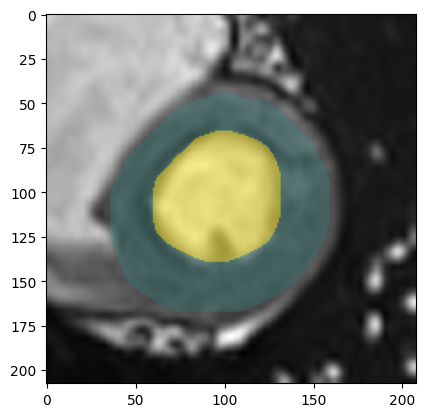

In [40]:
plt.imshow(preprocessed_image[:,:,5,5], 'gray')
plt.imshow(preprocessed_mask[:,:,5,5], alpha = preprocessed_mask[:,:,5,5]*0.25)




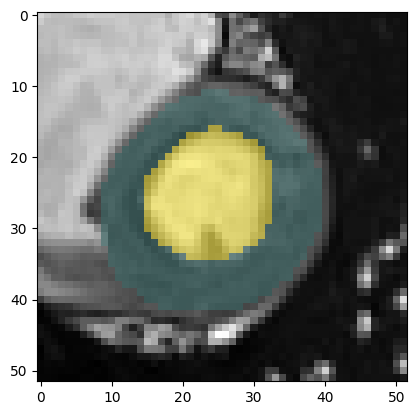

In [32]:
plt.imshow(preprocessed_image[:,:,5,5], 'gray')
plt.imshow(preprocessed_mask[:,:,5,5], alpha = preprocessed_mask[:,:,5,5]*0.25)




IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

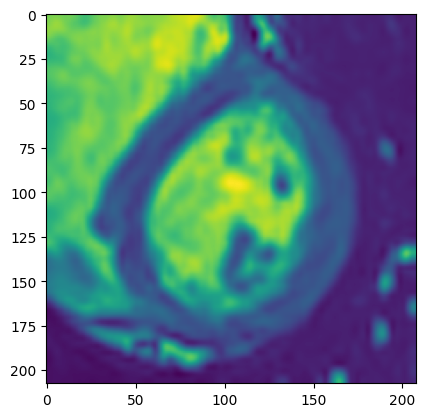

In [30]:
plt.imshow(preprocessed_image[:,:,5,0])
plt.imshow(preprocessed_mask[:,:,5,0,2], alpha = preprocessed_mask[:,:,5,0,2])


In [ ]:
plt.imshow(preprocessed_image[:,:,5,0])
plt.imshow(preprocessed_mask[:,:,5,0,2])